In [1]:
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import pandas as pd
import scipy.optimize as sc
import scipy

In [14]:
# Read CCD Calibration parameters
calibration_CCD = pd.read_csv('CCD_params.csv')

c_a = calibration_CCD['params_linear'][0]
c_b = calibration_CCD['params_linear'][1]
u_c_a = calibration_CCD['cov_linear'][0]
u_c_b = calibration_CCD['cov_linear'][1]


def wave(lamb, u_lamb):
    w = lamb * c_a + c_b
    u_w = np.sqrt((lamb * u_c_a)**2 + (u_c_b)**2 + (c_a * u_lamb)**2)
    return w, u_w
print(calibration_CCD['laser'])

w_laser = calibration_CCD['laser_corr']


def d_v(lamb, u_lamb):
    v = 1/w_laser[0] - 1/lamb
    u_v = np.sqrt((w_laser[1]/w_laser[0]**2)**2 + (u_lamb/lamb**2)**2)
    return v, u_v

0    531.817984
1    531.817984
Name: laser, dtype: float64


In [3]:
def lorentz(x, A, w0, gamma, C):
    '''Function of a Lorentz-curve.

    w0 : position of maximum
    gamma : curve width
    '''
    return A/((x**2 - w0**2)**2 + gamma**2 * w0**2) + C


def voigt(x, mean, sigma, gamma, A, c):
    return A * scipy.special.voigt_profile(x-mean, sigma, gamma) + c

def gauss(x, A, mu, sigma, C):
    return A * np.exp(-(x-mu)**2 / (2*sigma**2)) + C

def doppel_gauss(x, A1, mu1, sigma1, A2, mu2, sigma2, C):
    return (A1 * np.exp(-(x-mu1)**2 / (2*sigma1**2)) + A2 * np.exp(-(x-mu2)**2 / (2*sigma2**2))) + C

def linear(x,a,b):
    return a*x+b

In [4]:
def save_params(spectrum, coefficients, covariance):
    wavelength = []
    u_wavelength = []
    dvs = []
    u_dvs = []
    for i in range(len(coefficients)):
        if coefficients[i,1] > 0:
            w = wave(coefficients[i,1], np.sqrt(covariance[i,1,1]))
            wavelength.append(w[0])
            u_wavelength.append(w[1])
        
            nu = np.array(d_v(*w)) * 1e7
            dvs.append(nu[0])
            u_dvs.append(nu[1])
        
            print('lambda = {0:3.5g} \pm {1:1.2g}'.format(w[0], w[1]))
            print('d_nu = {0:3.3g} \pm {1:1.2g}'.format(nu[0], nu[1]))
        if coefficients[i,4] > 0:
            w = wave(coefficients[i,4], np.sqrt(covariance[i,4,4]))
            wavelength.append(w[0])
            u_wavelength.append(w[1])
        
            nu = np.array(d_v(*w)) * 1e7
            dvs.append(nu[0])
            u_dvs.append(nu[1])
            print('lambda = {0:3.5g} \pm {1:1.2g}'.format(w[0], w[1]))
            print('d_nu = {0:3.3g} \pm {1:1.2g}'.format(nu[0], nu[1]))

    output_data = pd.DataFrame({'$\lambda_{Mono}$': wavelength,
                                '$u(\lambda_{Mono})$': u_wavelength,
                                '$d_\nu$': dvs,
                                '$u(d_\nu)$': u_dvs})

    # output_data.to_csv('Calibration_Files_Mono/'+ spectrum + '.csv', index=False)
    print('Successfully saved!')
    return wavelength, u_wavelength, dvs, u_dvs

In [5]:
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

def draw_spectrum(num_fit, x, y, a, xaxis,xaxis1, coefficients,
                  covariance, title, concentration, func1=gauss,func2=gauss,
                  log=False, ylims=[0,200],
                  xlims=[5050,5600], avline=True):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(x, y, marker = 'x', lw = 0, ms = 5, color = 'grey')
    
    i=0
    j=1
    if func1==doppel_gauss:
        params = coefficients[i]
        cov = covariance[i]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_1 = ({:.2f} \pm {:.2f})\,$nm, $\mu_2 = ({:.2f} \pm {:.2f})\,$nm'.format(
            params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))

    elif func1==gauss:
        params = coefficients[i,:4]
        cov = covariance[i,:4,:4]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_1 = ({:.2f} \pm {:.2f})\,$nm'.format(
            params[1], np.sqrt(cov[1,1])))

    for i in range(1,num_fit-1):
        params = coefficients[i,:4]
        cov = covariance[i,:4,:4]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        j+=1
        ax.plot(xaxis[i],gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{} = ({:.2f} \pm {:.2f})\,$nm'.format(j, params[1], np.sqrt(cov[1,1])))
            
    i=i+1
    if func2==doppel_gauss:
        params = coefficients[i]
        cov = covariance[i]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_{} = ({:.2f} \pm {:.2f})\,$nm, $\mu_{} = ({:.2f} \pm {:.2f})\,$nm'.format(j+1,
            params[1], np.sqrt(cov[1,1]),j+2, params[4], np.sqrt(cov[4,4])))
    else:
        params = coefficients[i,:4]
        cov = covariance[i,:4,:4]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_{} = ({:.2f} \pm {:.2f})\,$nm'.format(j+1,
            params[1], np.sqrt(cov[1,1])))
    
    ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
    ax.set_ylabel(r'Intensity [a.u.]')
    ax.set_title(title, size=15)
    ax.axvline(calibration_CCD['laser'][0], ls='--', color = 'green', label=r'laser wavelength', lw=1)
    ax.legend()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    if log:
        ax.set_yscale('log')
    plt.tight_layout()
    # plt.savefig('Figures/Ethanol_'+str(concentration)+'_ml.pdf', dpi=800)
    plt.show()

In [6]:
def fit_func(N, x, y, a, p0s,p1s, func1, func2, show):
    coefficients = np.zeros((N, 7))
    covariance = np.zeros((N, 7, 7))
    i = 0
    if func1==gauss:
        params, cov = sc.curve_fit(func1, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p0s[i])
        coefficients[i,:4] = params
        covariance[i,:4,:4] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
    elif func1==doppel_gauss:
        params, cov = sc.curve_fit(func1, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p1s[0])
        coefficients[i] = params
        covariance[i] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))

    for i in range(1,N-1):
        params, cov = sc.curve_fit(gauss, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]], p0 = p0s[i])
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
        coefficients[i,:4] = params
        covariance[i,:4,:4] = cov
    i = i+1
    if func2==gauss:
        params, cov = sc.curve_fit(func2, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p0s[i])
        coefficients[i,:4] = params
        covariance[i,:4,:4] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
    elif func2==doppel_gauss:
        params, cov = sc.curve_fit(func2, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p1s[1])
        coefficients[i] = params
        covariance[i] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
    return coefficients, covariance

**Sulphur Spectrum**

In [92]:
def Temperature(I,uI, wavelength, u_wavelength, dvs, u_dvs):
    h = scipy.constants.h
    k = scipy.constants.k
    c = scipy.constants.c
    dv1 = np.mean([np.abs(dvs[0]*c*1e2), np.abs(dvs[3]*c*1e2)])
    dv2 = np.mean([np.abs(dvs[1]*c*1e2), np.abs(dvs[2]*c*1e2)])
    udv1 = np.sqrt(np.abs(u_dvs[0]*c*1e2)**2 + np.abs(u_dvs[3]*c*1e2)**2)
    udv2 = np.sqrt(np.abs(u_dvs[1]*c*1e2)**2 + np.abs(u_dvs[2]*c*1e2)**2)
    # print('dv1=', dv1,'+-',udv1, udv1/dv1)
    # print('dv2=', dv2,'+-',udv2, udv2/dv2)
    
    z1 = I[3]/I[0]*wavelength[3]**4/wavelength[0]**4
    z2 = I[2]/I[1]*wavelength[2]**4/wavelength[1]**4
    
    uz1 = z1 * np.sqrt((uI[3]/I[3])**2 + (3*u_wavelength[3]/wavelength[3])**2
                       + (uI[0]/I[0])**2 + (4*u_wavelength[0]/wavelength[0])**2)

    uz2 = z2 * np.sqrt((uI[2]/I[2])**2 + (3*u_wavelength[2]/wavelength[2])**2
                       + (uI[1]/I[1])**2 + (4*u_wavelength[1]/wavelength[1])**2)

    # print("z1=", z1, uz1, uz1/z1)
    # print("z2=", z2, uz2, uz2/z2)
    
    T1 = h*dv1/k * 1/np.log(z1)
    T2 = h*dv2/k * 1/np.log(z2)
    
    uT1 = np.sqrt((h/k/np.log(z1) * udv1)**2 + (h*dv1/k/z1/(np.log(z1))**2*uz1)**2)
    uT2 = np.sqrt((h/k/np.log(z2) * udv2)**2 + (h*dv2/k/z2/(np.log(z2))**2*uz2)**2)
    # print("T1=",T1, uT1, uT1/T1, "T2=", T2, uT2, uT2/T2)
    return T1, uT1, T2, uT2

[4.65377213e+03 5.18699564e+02 3.17388588e-01 1.36220507e+03
 5.19745535e+02 5.57730384e-01 6.00975127e+02] [2.00880240e+02 1.39723308e-02 1.35695094e-02 1.22196935e+02
 8.81034935e-02 8.91509430e-02 1.14835950e+02]
[6.97226262e+03 5.44386989e+02 2.80459335e-01 3.87396041e+04
 5.45548077e+02 3.43613911e-01 1.22138153e+04] [1.47787078e+03 5.09258722e-02 6.70880831e-02 1.24106825e+03
 8.33286575e-03 1.44634642e-02 1.20342335e+03]


<ipython-input-104-57f108f1dc0f>:32: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


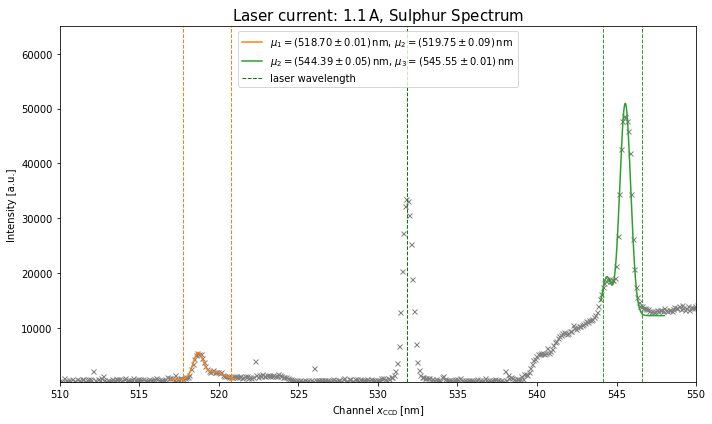

lambda = 519.01 \pm 0.17
d_nu = -474 \pm 8.7
lambda = 520.06 \pm 0.19
d_nu = -436 \pm 9.3
lambda = 544.67 \pm 0.18
d_nu = 433 \pm 8.6
lambda = 545.83 \pm 0.17
d_nu = 472 \pm 8.4
Successfully saved!
[6.49576412e+03 5.18702429e+02 3.20817541e-01 1.85434597e+03
 5.19760325e+02 5.68606704e-01 7.39002767e+02] [2.57318467e+02 1.25206820e-02 1.23302127e-02 1.53642518e+02
 8.26598321e-02 8.47202093e-02 1.44844130e+02]
[8.79144376e+03 5.44371496e+02 2.60334392e-01 4.40764361e+04
 5.45547298e+02 3.71841659e-01 1.83472027e+04] [1.62473246e+03 5.30501219e-02 6.74715141e-02 1.33314554e+03
 1.03026226e-02 1.54693550e-02 1.11409860e+03]


<ipython-input-104-57f108f1dc0f>:32: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


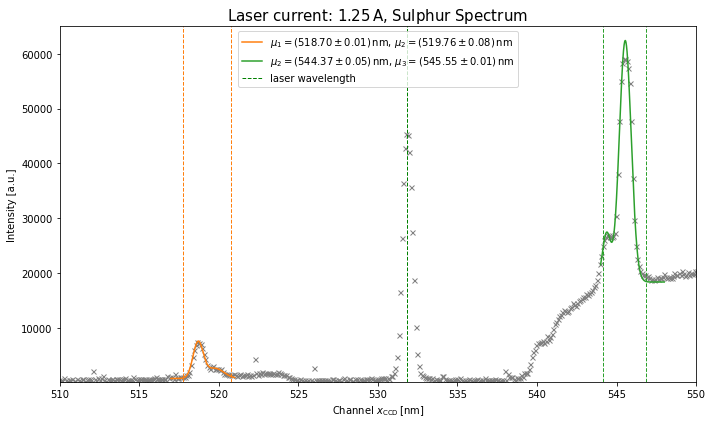

lambda = 519.02 \pm 0.17
d_nu = -474 \pm 8.7
lambda = 520.07 \pm 0.19
d_nu = -435 \pm 9.2
lambda = 544.65 \pm 0.18
d_nu = 433 \pm 8.6
lambda = 545.83 \pm 0.17
d_nu = 472 \pm 8.4
Successfully saved!
[5.73192229e+03 5.18720273e+02 3.18605452e-01 1.66577087e+03
 5.19771754e+02 5.73018378e-01 7.09012928e+02] [2.52861332e+02 1.33086828e-02 1.31748654e-02 1.41823223e+02
 8.93226630e-02 9.22471369e-02 1.31827064e+02]
[7.63862267e+03 5.44404987e+02 2.60081207e-01 4.17939406e+04
 5.45567764e+02 3.57971661e-01 1.78898165e+04] [1.48584426e+03 5.20105764e-02 6.59141365e-02 1.22896832e+03
 9.70535977e-03 1.42832971e-02 1.00455702e+03]


<ipython-input-104-57f108f1dc0f>:32: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


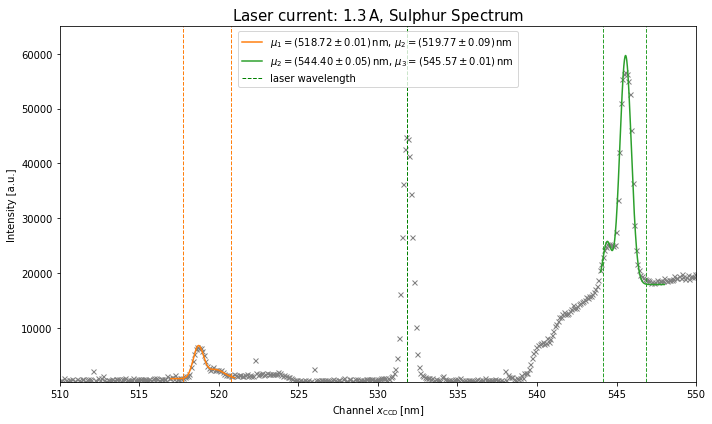

lambda = 519.03 \pm 0.17
d_nu = -474 \pm 8.7
lambda = 520.08 \pm 0.19
d_nu = -435 \pm 9.3
lambda = 544.69 \pm 0.18
d_nu = 434 \pm 8.6
lambda = 545.85 \pm 0.17
d_nu = 473 \pm 8.4
Successfully saved!
[6.15784059e+03 5.18724938e+02 3.21639277e-01 1.81110551e+03
 5.19764647e+02 5.90419563e-01 7.78078864e+02] [2.93591263e+02 1.29343448e-02 1.30495646e-02 1.44599370e+02
 9.47689192e-02 9.63231529e-02 1.36012432e+02]
[8.20581171e+03 5.44397856e+02 2.60085012e-01 4.19885007e+04
 5.45574621e+02 3.73656128e-01 2.02324430e+04] [1.61587266e+03 5.25689539e-02 6.64767187e-02 1.33449497e+03
 1.05912373e-02 1.62198440e-02 1.14245934e+03]


<ipython-input-104-57f108f1dc0f>:32: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


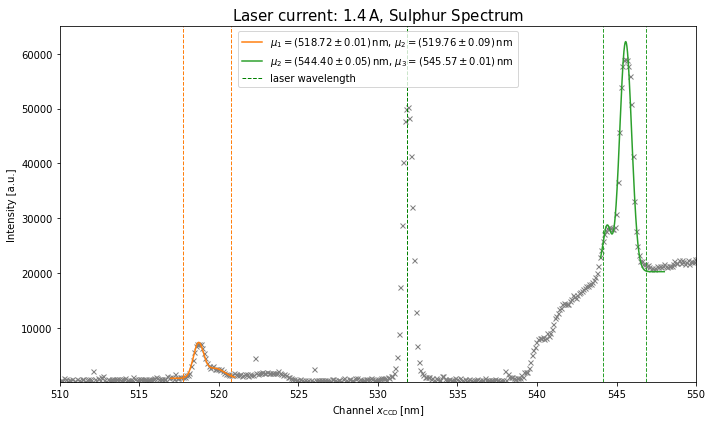

lambda = 519.04 \pm 0.17
d_nu = -473 \pm 8.7
lambda = 520.08 \pm 0.19
d_nu = -435 \pm 9.4
lambda = 544.68 \pm 0.18
d_nu = 434 \pm 8.6
lambda = 545.85 \pm 0.17
d_nu = 473 \pm 8.4
Successfully saved!
[4.58001183e+03 5.18713355e+02 3.30325450e-01 1.41312967e+03
 5.19767491e+02 6.12836498e-01 5.66471994e+02] [2.50450505e+02 1.40061116e-02 1.45435167e-02 1.17721761e+02
 1.04128777e-01 1.06500007e-01 1.13570911e+02]
[5.82842407e+03 5.44395137e+02 2.55916340e-01 3.67223148e+04
 5.45558291e+02 3.52437999e-01 1.70303340e+04] [1.14277896e+03 5.24763788e-02 6.62755150e-02 9.42248015e+02
 8.37840212e-03 1.21759589e-02 7.54153194e+02]


<ipython-input-104-57f108f1dc0f>:32: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


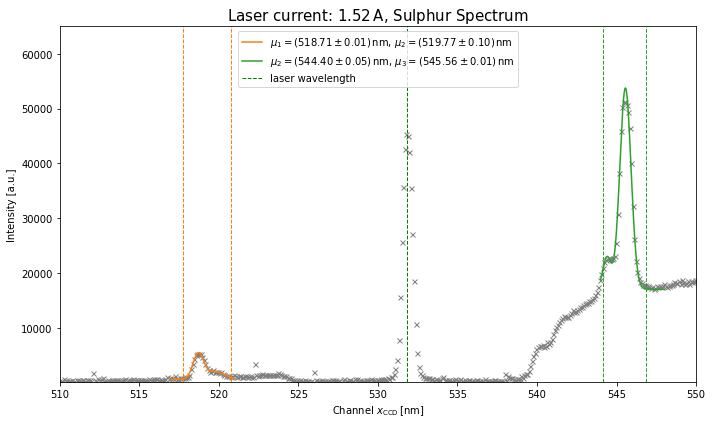

lambda = 519.03 \pm 0.17
d_nu = -474 \pm 8.7
lambda = 520.08 \pm 0.2
d_nu = -435 \pm 9.5
lambda = 544.68 \pm 0.18
d_nu = 433 \pm 8.6
lambda = 545.84 \pm 0.17
d_nu = 472 \pm 8.4
Successfully saved!


In [104]:
currents = [1.10, 1.25, 1.30, 1.40, 1.52]
n = len(currents)
a = [[[905, 935], [1176, 1202]],
     [[905, 935], [1176, 1205]],
     [[905, 935], [1176, 1205]],
     [[905, 935], [1176, 1205]],
     [[905, 935], [1176, 1205]]]
p0s = [[1e4, 519, 1, 1e3], [8e3, 564, 1, 1e3]]
p1s= [[4.5e3, 519, .3, 1.3e3, 520, .3, 1e2], [7e3, 544, 0.2, 4e4, 545.5, .3, 1e4]]
xaxis = [np.linspace(517, 521, 1001), np.linspace(544, 548, 1001)]
xaxis1 = []
func1, func2 = doppel_gauss, doppel_gauss

parameters = np.zeros((n, 2, 7))
u_params = np.zeros((n,2, 7,7))
Temperatures = np.zeros((n,2,2))

for i in range(len(currents)):
    current = currents[i]
        
    file = 'CCD/sulphur_' + str(round(current*100)) + 'A.txt'
    df = pd.read_csv(file, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'],
                     decimal=',', engine = 'python')
    title = 'Laser current: ' + str(current)+r'$\,$A, Sulphur Spectrum'
    N = 2

    y_counts = df['Counts']
    
    coefficients, covariance = fit_func(N=N, x=df['Channel'], y=y_counts, a=a[i],
                                        p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=True)
    parameters[i,:] = coefficients
    u_params[i,:] = np.sqrt(covariance)
    draw_spectrum(num_fit=N, x=df['Channel'], y=y_counts, a=a[i], xaxis=xaxis,
                  xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
                  func1=func1, func2=func2,concentration=current,log=False,ylims=[100,65000],
                  xlims=[510,550],avline=True)
    wavelength, u_wavelength, dvs, u_dvs = save_params(current, coefficients, covariance)
    I = np.array([coefficients[0,0], coefficients[0,3], coefficients[1,0], coefficients[1,3]])
    u_I = np.sqrt(np.array([covariance[0,0,0], covariance[0,3,3], covariance[1,0,0], covariance[1,3,3]]))
    # print("I=",I)
    # print(u_I)
    # print(wavelength)
    T1, uT1, T2, uT2 = Temperature(I, u_I, np.array(wavelength), np.array(u_wavelength), np.array(dvs), np.array(u_dvs))
    Temperatures[i,0,:] = T1, uT1
    Temperatures[i,1,:] = T2, uT2

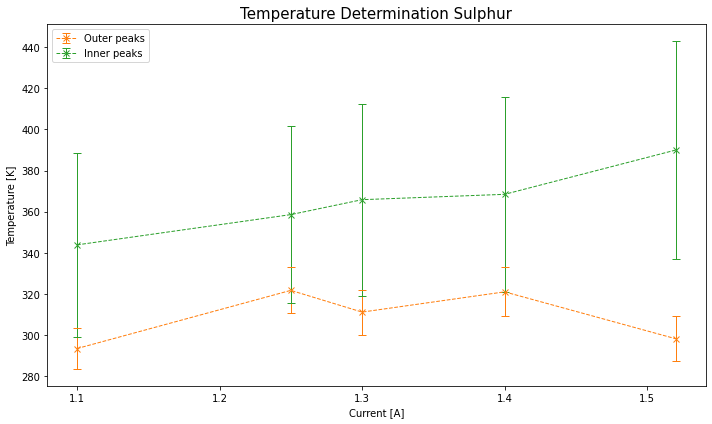

35.95249099975763 4.945200623872675 0.1375482056001631
92.1870325049369 21.069209696669628 0.2285485184214093


In [133]:
fig, ax = plt.subplots(figsize=(10,6))
z = np.average(Temperatures[:,:,0], axis = 1)
uz = 1/2 * np.sqrt(Temperatures[:,0,1]**2 + Temperatures[0,1,1]**2)
ax.errorbar(currents, Temperatures[:,0,0], yerr=Temperatures[:,0,1], capsize=4,
            marker = 'x', lw=1, ls = '--', color = colors[0], label = 'Outer peaks')
ax.errorbar(currents, Temperatures[:,1,0], yerr=Temperatures[:,1,1], capsize=4,
            marker = 'x', lw=1, ls = '--', color = colors[1], label='Inner peaks')
# ax.errorbar(currents, z, yerr = uz,  marker = 'x', lw=2, ls='--', ms=10, capsize=5, label = 'Mean')
ax.set_ylabel(r'Temperature [K]')
ax.set_xlabel(r'Current [A]')
ax.set_title(r'Temperature Determination Sulphur', size=15)
ax.legend()
plt.tight_layout()
plt.show()
# print(np.mean(np.mean(Temperatures[:,:,0],axis=1))-273.15)
T0 = np.mean(Temperatures[:,0,0])-273.15
T1 = np.mean(Temperatures[:,1,0])-273.15
uT0 = 1/5 * np.sqrt(np.sum(Temperatures[:,0,1]**2))
uT1 = 1/5 * np.sqrt(np.sum(Temperatures[:,1,1]**2))
print(T0, uT0, uT0/T0)
print(T1, uT1, uT1/T1)